## <strong> 0. Abstract </strong>

당시 Convolutinal network는 다양한 분야에서 최신 cv기술 중 핵심이었다고 한다. <br>
2014부터 깊은 convolutional network들이 대세가 되기 시작했고, 다양한 benchmark에서 상당한 성과를 얻었다. <br>
model의 커진 size와 computational cost가 대부분의 task에서 즉각적인 성능 향상을 얻는 경향이 있었다. <br>
한 계산의 효율과 적은 파라미터 개수는 mobile vision, big-data scenarios 등 다양한 케이스에 기술을 사용가능하게 해준다. <br>
아래 방법들은 해당 논문에서 모델의 크기를 효율적으로 증가시키기 위해 사용한 방식이다.

* **factorized convolutions**
* **aggressive regularization**

해당 모델을 ILSVRC 2012 classification challenge의 validation set에 적용했을 때 상당한 성능 향상을 얻었다고 한다. 

* single frame evaluation: top-1: 21.2% / top-5: 5.6%
* ensemble of 4 models: top-1: 17.3% / top-5: 3.5%

## <strong> 1. Introduction </strong>

2012년 AlexNet이 ImageNet competition에서 우승한 후 object-detection, segmentation, human pose estimation 등 여러 분야에 성공적으로 적용되었다. <br>

이러한 성공은 convolutional neural network(cnn)를 더 잘 수행하는 방법에 초점을 맞춰 연구하도록 자극했다. <br> 2014년부터 **더 deep하고 더 wide한 network들로 인해 network architecture들의 성능은 상당히 발전했다.** <br>
VGGNet과 GoogLeNet은 2014 ILSVRC classification challenge에서 높은 성과를 냈다. <br>
이때 classification performance의 성능 향상은 다양한 적용 분야의 상당한 성능 향상으로 이어진다. <br>
즉, deep convolutional architecture의 구조적 향상은 visual feature에 의존하는 대부분의 cv task들의 성능을 향상시키는 데 사용될 수 있다. <br>
또한 network의 발전은 새로운 적용 분야를 만들어냈다.

비록 **VGGNet이 단순하지만 너무 많은 비용이 들어간다.** <br>
반면 **GoogLeNet의 Inception 구조는 memory와 computational budget의 엄격한 규제(constraint) 아래에도 잘 수행되도록 설계되어 있다.**

* GoogLNet: 5million parameters, which represented a 12× reduction with respect to its predecessor AlexNet(60 million parameters)

Inception의 computational cost는 VGGNet보다 더 적으며 더 좋은 성능을 보여준다. <br>
위 결과는 많은 데이터가 상당한 cost로 처리될 필요가 있는 big-data scenario 혹은 mobile vision 환경과 같이 memory혹은 computational capacity가 제한된 scenario에 Inception Networks를 활용 가능하게 해준다.

하지만 Inception의 complexity는 network를 바꾸는데 어렵게 한다. <br>
만약 architecture을 단순히 늘린다면 계산적 장점의 많은 부분을 잃을 수 있다. <br>
또한 GoogLeNet architecture의 다양한 design 결정을 이끌어낸 기여 요소들에 대한 명확한 설명을 제공하지 않았다. <br>
이는 GoogLeNet의 효율성을 유지하면서 새로운 활용 사례에 적용하기 어렵게 한다. <br>
예를 들어, 만약 몇몇 Inception-style model의 capacity를 증가시킬 필요가 있다고 생각했다면 단순히 모든 filter bank 크기를 2배로 올리는 방법은 computational cost와 parameter 개수를 둘 다 4배로 증가시킨다. <br>
하지만 위와 같은 방식은 많은 현실적인 scenario에 사용할 수 없다.

이 논문은 효율적인 방법으로 convolution network의 크기를 늘리데 유용한 몇 가지 general principle들과 opimization idea들을 설명하면서 시작할 것이다. <br>
비록 이 원칙들이 Inception-type network에만 국한된 것은 아니지만, inception style building block의 포괄적 구조는 이 제약들을 포함하기에 충분히 유연하다는 맥락에서 관측하기 더 쉽다. <br>
이것은 근처 구성요소의 구조적 변화 영향을 완화하게 해주는 Inception model의 dimensional reduction과 parallel structure를 사용하므로써 가능하게 된다. <br>
하지만 모델의 성능을 유지하기 위해 몇 가지 원리를 준수해야 하므로 위처럼 하는 것에 대한 주의는 필요하다.

## <strong> 2. General Design Principles </strong>

* **Avoid representational bottlenecks, especially early in the network** <br> -> Representational bottleneck이 발생하지 않도록 representation은 서서히 감소해야 한다. 

* **Higher dimensional representations are easier to process locally within a network** <br> ->
Conv Layer의 activation map 개수를 늘리면 disentangled feature를 많이 얻을 수 있으며, 네트워크가 더 빨리 학습할 수 있다.

* **Spatial aggregation can be done over lower dimensional embeddings without much or any loss in representational power** <br> -> 
Conv 연산을 다수 수행할 때 적절한 dimension reduction을 해주는 것이 빠른 학습에 도움이 된다.

* **Balance the width and depth of the network** <br> ->
network의 width와 depth를 늘리면 성능 향상에 도움이 된다. 단, depth와 width를 균형있게 구성해야 한다.

이러한 원칙들이 타당하긴 하지만, 이를 활용해서 네트워크의 성능을 향상시키는 것은 간단하지 않다고 한다. <br>
따라서, 모호한 상황에서만 이 아이디어들을 고려하도록 하자.



## <strong> 3. Factorizing Convolutions with Large Filter Size </strong>

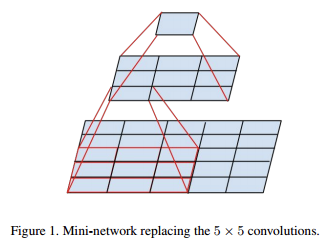

5×5, 7×7 convolution을 3×3 convolution으로 분해하면 연산량과 파라미터를 감소시킬 수 있다. 

* 5×5 -> 3×3 filter 2개 / 7×7 -> 3×3 filter 3개로 분해 가능하다.


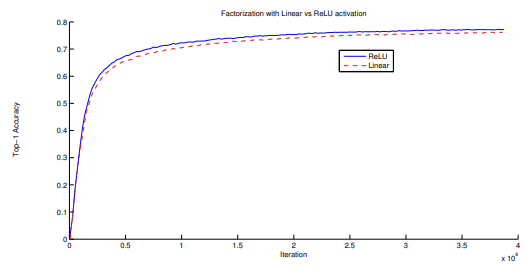

5x5 convolution을 분해할 때, 첫 번째 3x3은 linear activation, 두 번째 3x3은 ReLU activation을 사용하는 것과 둘 다 ReLU activation을 사용하는 것을 실험했다고 한다. 결과는 위처럼 두 3x3 convolution에 ReLU를 사용한 것이 정확도가 더 높았다. 추가적으로 BN을 사용하면 더 정확도가 높다고 한다.

* 그래프 결과: After 3.86 million iteration, 77.2% and 76.2% top-1 accuracy

위 결과에 따르면 3×3 보다 큰 filter는 3×3의 Sequence로 줄일 수 있기 때문에 일반적으로 사용되지 않는다. <br>
이때 3×3보다 2×2 filter로 줄일 수도 있다. <br>
하지만 n×1과 같이 비대칭(asymmetric) convolution을 사용하는 것이 좋다고 알려져 있다.

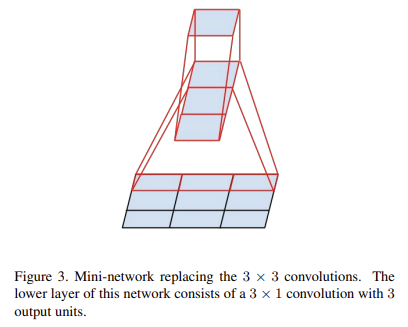

단, 위와 같은 구조는 **feature map이 medium grid size(m×m feature map에서 m의 범위가 12~20인 경우)일 때 가장 좋은 결과를 출력한다고 한다.** <br>
실제로 Inception v2의 구조를 보면 feature map(input)의 크기가 17×17인 층에서 7×1, 1×7 convolution을 사용한다.

## <strong> 4. Utility of Auxiliary Classifiers </strong>

이전 original Inception model는 deep network에서 convergence를 개선하기위해 auxiliary classifier를 사용했다. <br>
하지만 연구진들은 auxiliary classifier가 학습 초기에 **별다른 효과가 없는 것을 확인했다.** 

* 두 model이 높은 accuracy에 도달하기 전에 auxiliary classifier가 있는 model과 없는 model의 학습은 거의 동일했다고 한다.

학습 종료 시점에 auxiliary branch들이 존재하는 network가 auxiliary branch가 없는 network의 accuracy를 능가했고 살짝 더 안정적이었다고 한다.

GoogLeNet에서는 다른 stage에서 두 개의 auxiliary classifier를 사용했다. <br>
이때 더 낮은 층의 auxiliary branch를 제거해도 network의 성능에 아무런 영향도 주지 않는다고 한다. <br>

즉, 위 내용들은 기존 가설이 틀렸다는 것을 의미한다. <br>
대신에 연구진들은 auxiliary classifier에 bn 혹은 dropout layer를 적용했을 때 main classifier가 좋은 성능을 냈기 때문에 regularizer로 작동한다고 주장한다. <br>

Inception-v2에서는 아래와 같은 auxiliary classifier를 17×17 layer의 마지막 층에 적용했다고 한다. <br>
그 결과 top-1 accuracy가 0.4% 올랐다고 한다.

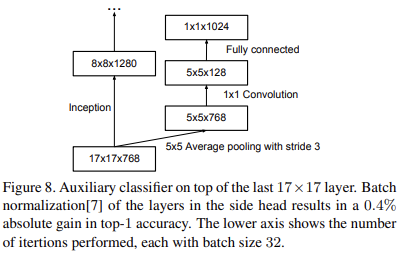




## <strong> 5. Efficient Grid Size Reduction </strong>

일반적인 CNN 연산은 feature map의 size를 줄이기 위해 pooling 연산을 수행한다. <br>
그리고 representational bottleneck을 피하기 위해 channel(filter 개수)을 증가시킨다.

아래 좌측처럼 pooling후 CNN을 수행하면 CNN을 적용하기 전에 손실이 발생한다. <br> **즉, 연산량을 줄여주지만 신경망의 representation도 감소시킨다.** <br>
반면 CNN연산을 수행하고 pooling을 수행하면 **representation을 감소시키진 않지만 연산량이 증가한다.**

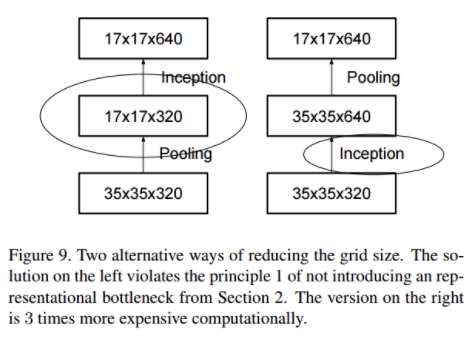



논문에서는 위와 같은 문제를 보완하기 위해 각각 stride가 2인 pooling layer와 conv layer를 병렬로 사용한다. <br>
이 방법을 사용하면 representation을 감소시키지 않고 연산량을 감소시킬 수 있다고 한다. <br>
이때 두 block의 filter bank는 concatenate로 연결된다.

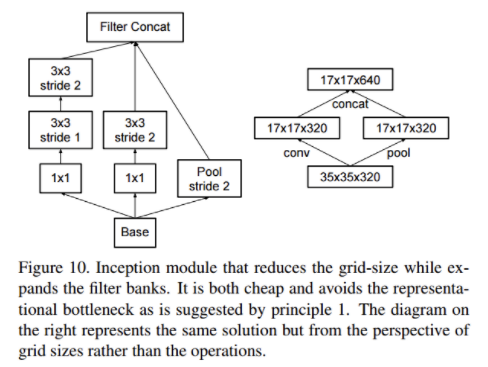

## <strong> 6. Inception-v2 </strong>

Inception은 아래와 같이 총 3개의 종류로 구분된다. <br>
각각 Figure 5, 6, 7을 나타낸다.

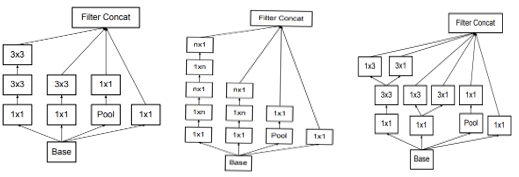

* Figure7: <br>
Filter bank size를 확장한 Inception module이며, grid size가 가장 축소됐을 때 사용한다. <br>
Grid size가 작아졌으므로 그만큼 high dimensional representation하므로 2번 principle에 따라 locally하게 처리했다고 한다.

Inception-v2의 구조는 다음과 같다.

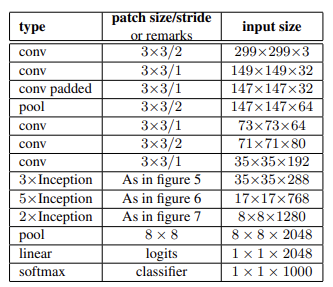

* 7×7 Conv -> Three 3×3 Conv
* 35×35->17×17 / 17×17->8×8 Grid reduction: apply Figure 10

Inception-v2는 총 42층이지만 GoogLeNet에 비해 단 2.5배 만큼만 연산량이 많고 VGGNet보다 효율적이라고 한다.

## <strong> 7. Model Regularization via Label Smoothing </strong>

논문에서 소개한 Label Smoothing 방식은 모델의 일반화 성능을 높였다고 한다.
* Ex) [0, 1, 0, 0] -> [0.025, 0.925, 0.025, 0.025]

위와 같은 방식을 사용하면 정답에 대한 확신을 감소시켜 일반화된 성능을 나타낼 수 있다고 한다. <br>
논문에서 사용한 공식은 다음과 같다.

$newLabels = (1-ϵ) * oneHotLabels + ϵ / K$

## <strong> 8. Training Methodology </strong>

* Batch size: 32 <br>
* Epoch: 100 <br>
* Optimizer: (ealier) momentum, decay=0.9 / (best) RMSProp, decay=0.9, $ϵ$=1.0 <br>
* Learning rate: (initial) 0.045, decayed every two epoch using an exponential rate of 0.94


## <strong> 9. Performance on Lower Resolution Input </strong>

vision network의 전형적인 활용 사례에는 Multibox context와 같은 detection의 post-classification가 있다. <br>

* post-classification: Detected object에 대한 classification을 말하는 것 같다.

이것은 몇 가지 context와 single object를 담고있는 이미지의 상대적인 작은 patch에 대한 분석을 포함한다. <br>
이미지 patch의 분석은 patch의 중앙 부분이 어떤 object인지 판단하고 object의 클래스를 결정한다. <br>
문제는 그 objects들이 상대적으로 작고 낮은 해상도인 경향이 있다는 것이다. <br>
이러한 문제는 어떻게 lower resolution input을 적절하게 처리해야 하는지 의문을 남긴다. 

model이 higher resolution receptive filed를 사용하면 recognition performance에 상당한 향상을 가져온다고 알려져 있다. <br>
**하지만 first layer receptive field의 향상된 resolution의 효과와 더 큰 model에 따른 capacitance와 computation의 효과인지 구별하는 것은 중요하다.** <br>
만약 우리가 model의 추가적인 조정없이 input의 resolution을 바꿨다면 우리는 연산적으로 훨씬 싼 model을 더 복잡한 task에 사용한 것이다. <br>
computational effort가 줄어들기 때문에 자연스럽게 이 해결법의 견고함도 떨어진다. <br>
정확한 평가를 하기 위해 알맞은 세부사항을 hallucinate(환각을 보다/듣다) 할 수 있게 하기 위해 model은 모호한 hint들을 분석해야 한다. <br>
이것은 연산적으로 비싸다. (즉, 층을 추가해 추가적인 특징을 추출해야 한다는 의미인 것 같다.)

그렇다면 computational effort가 고정될 때 더 높은 input resolution은 어떻게 도움을 줄까? <br>
constant effort를 보장하기 위한 간단한 방법은 lower resolution input의 첫 번째 2개의 layer의 stride를 줄이거나 첫 번째 pooling layer를 삭제하면 된다.

* 299×299 receptive field: stride 2 and maximum pooling after first layer
* 155×155 receptive field: stride 1 and maximum pooling after first layer
* 79×79 receptive field: stride 1 and without pooling after first layer

위 세 개의 networks는 거의 동일한 연산량을 가진다고 한다. <br>
실제로 3번 network가 약간 저렴하지만 pooling layer의 계산 비용은 총 비용의 1% 이내이므로 무시한다고 한다.
위 network들의 평가는 ImageNet ILSVRC 2012 classification benchmark의 validation set으로 이루어졌다. <br>
결과는 다음과 같다.

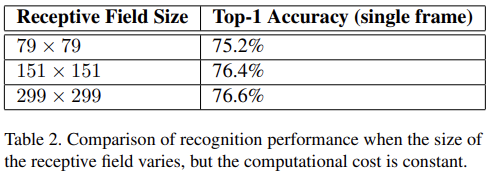

**결과적으로 lower-resolution network가 학습하는 데 오래 거리지만 성능은 higher resolution network에 근접했다.** <br>
이는 R-CNN의 smaller object에 대해, hight-cost low resolution network의 사용 가능성을 암시한다고 한다.

## <strong> 10. Experimental Results and Comparisons </strong>

Table 3는 Inception-v2의 실험 결과이다. 

* 아래 결과는 Inception-v2에 위에서 설명한 각 방식을 적용한 single-crop 성능이다. 
* BN-auxiliary는 Conv layer뿐만 아니라 Fc layer에도 BN을 적용한다.
* Inception-v3는 아래 기법들을 모두 적용한 Inception-v2이다.

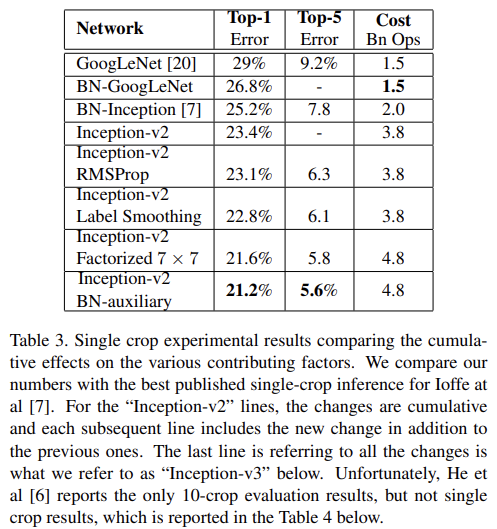

이후 각 모델을 multi-crop와 ensemble 환경에서 평가했다고 한다.

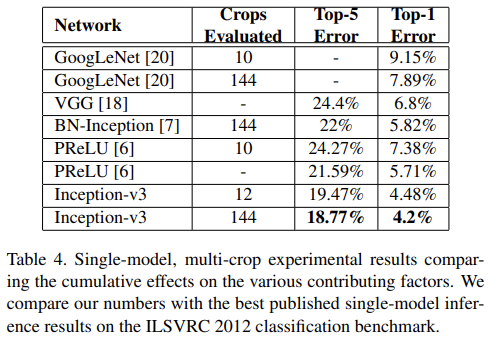

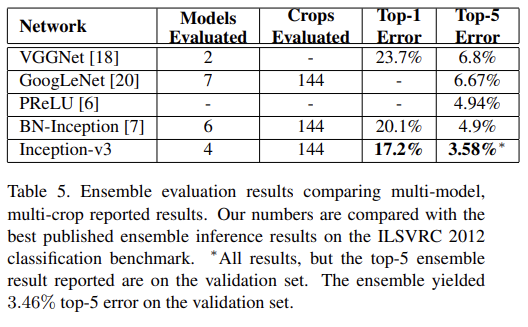